# This notebook shows data aggregation, exploratory analysis and model development

In [1]:
from data_prep import *
import csv
import time 
from random import randint
import glob
import sys
import matplotlib.pyplot as plt
%matplotlib inline
from scipy.interpolate import interp1d
import pickle
import os

 ...Loading Master Dictionary 85000
Master Dictionary loaded from file: 
  LoughranMcDonald_MasterDictionary_2014.csv
  85,131 words loaded in master_dictionary.



In [2]:
# Merge earnings call features with stock info for one company
def one_company_earnings_stock(company_name,time_window):
    
    # Load earnings call csv data
    path = os.getcwd()
    path = path[:-3]
    path = path + 'data/'
    earnings_txt = pd.read_csv(path + company_name + '_earnings_call.csv')
    
    # Offset 12 hours because (1) UTC is 4 or 5 hours ahead ET 
    # (2) the transcript could be posted the next morning if the call was at late evening. 
    time_earnings = pd.to_datetime(earnings_txt['time']) - timedelta(days=0.5)
    time_earnings = pd.to_datetime(time_earnings.apply(datetime.date))
    
    # Extract tones from earnings call transcript
    tones = earnings_txt['full_text'].apply(parse_one_call_transcript)
    tone_intro = []
    tone_qna = []
    tone_ab = []
    for tone in tones:
        tone_intro.append(tone[0])
        tone_qna.append(tone[1])
        tone_ab.append(tone[2])
    
    # Insert earnings call tones and company name into a data frame
    earnings_stock = pd.DataFrame(time_earnings,columns = ['time'])
    ticker = ticker_list[company_name]
    earnings_stock['company'] = ticker
    earnings_stock['tone_intro'] = tone_intro
    earnings_stock['tone_qna'] = tone_qna
    earnings_stock['tone_ab'] = tone_ab
    
    # Compute stock change
    stock_change = earnings_stock['time'].apply(compute_stock_prop,args = (ticker,time_window))
    price_change = []
    vola_change = []
    for change in stock_change:
        price_change.append(change[0])
        vola_change.append(change[1])
        
    # Add stock info to the data frame
    earnings_stock['price_change'] = price_change
    earnings_stock['vola_change'] = vola_change   
        
    return earnings_stock

# Exploratory data analysis, have a sense of earnings call and stock for each tech company

In [3]:
earnings_stock_apple = one_company_earnings_stock("Apple",[10,10])
earnings_stock_apple.head()

,time,company,tone_intro,tone_qna,tone_ab,price_change,vola_change
0,2018-02-01,AAPL,2.150873,0.374625,1.776247,-0.056756,0.286357
1,2018-05-01,AAPL,2.279202,0.935270,1.343933,0.109138,-0.027829
2,2018-07-31,AAPL,2.106742,0.402253,1.704489,0.082873,0.471193
3,2018-11-01,AAPL,2.369668,0.630252,1.739416,-0.080730,1.200595
4,2017-01-31,AAPL,2.786710,1.045053,1.741656,0.088377,1.458118


In [4]:
earnings_stock_google = one_company_earnings_stock("Google",[10,10])
earnings_stock_google.head()

,time,company,tone_intro,tone_qna,tone_ab,price_change,vola_change
0,2018-10-25,GOOG,1.778305,1.191620,0.586684,-0.033791,0.173274
1,2018-07-23,GOOG,1.868101,1.415094,0.453006,0.043541,0.082779
2,2018-04-23,GOOG,2.259887,1.182772,1.077115,-0.019830,-0.475137
3,2018-02-01,GOOG,2.312139,0.718798,1.593341,-0.090228,1.673856
4,2017-10-26,GOOG,1.880141,1.122083,0.758058,0.045064,-0.238424


In [5]:
earnings_stock_facebook = one_company_earnings_stock("Facebook",[10,10])
earnings_stock_facebook.head()

,time,company,tone_intro,tone_qna,tone_ab,price_change,vola_change
0,2018-10-30,FB,1.259876,1.160578,0.099298,-0.018333,-0.303639
1,2018-07-25,FB,1.351351,1.034956,0.316395,-0.155410,0.605153
2,2018-04-25,FB,1.471490,0.673092,0.798398,0.067980,0.035802
3,2018-01-31,FB,1.247554,0.897505,0.350049,-0.028465,1.197812
4,2017-11-01,FB,1.056803,0.393627,0.663176,0.020555,-0.821518


In [6]:
earnings_stock_twitter = one_company_earnings_stock("Twitter",[10,10])
earnings_stock_twitter.head()

,time,company,tone_intro,tone_qna,tone_ab,price_change,vola_change
0,2018-10-25,TWTR,0.257290,1.332659,-1.075369,0.166283,-0.214468
1,2018-07-27,TWTR,0.401204,1.114674,-0.713470,-0.245416,-0.834133
2,2018-04-25,TWTR,0.849858,1.676758,-0.826900,0.010407,-0.280025
3,2018-02-08,TWTR,1.580460,1.659429,-0.078970,0.252142,-0.432899
4,2017-10-26,TWTR,2.311436,1.406719,0.904716,0.117179,-0.155694


In [7]:
earnings_stock_ibm = one_company_earnings_stock("IBM",[10,10])
earnings_stock_ibm.head()

,time,company,tone_intro,tone_qna,tone_ab,price_change,vola_change
0,2019-01-22,IBM,1.225337,0.636943,0.588395,0.103278,-0.198813
1,2018-10-16,IBM,1.412503,0.649892,0.762612,-0.130027,0.177912
2,2018-07-18,IBM,1.325869,0.888287,0.437583,0.011290,-0.028285
3,2018-04-17,IBM,1.653294,0.781250,0.872044,-0.060312,-0.571391
4,2018-01-18,IBM,1.229508,1.085973,0.143535,0.000784,-0.233054


In [8]:
earnings_stock_amazon = one_company_earnings_stock("Amazon",[10,10])
earnings_stock_amazon.head()

,time,company,tone_intro,tone_qna,tone_ab,price_change,vola_change
0,2018-10-25,AMZN,-1.558442,0.694611,-2.253052,-0.074304,0.683891
1,2018-07-26,AMZN,-1.538462,1.487955,-3.026416,0.003950,1.150113
2,2018-04-26,AMZN,-1.530612,0.680581,-2.211193,0.060818,-0.624602
3,2018-02-01,AMZN,-0.854701,1.145931,-2.000632,0.019169,-0.149928
4,2017-10-26,AMZN,-1.530612,0.543725,-2.074337,0.127623,-0.182551


In [9]:
earnings_stock_microsoft = one_company_earnings_stock("Microsoft",[10,10])
earnings_stock_microsoft.head()

,time,company,tone_intro,tone_qna,tone_ab,price_change,vola_change
0,2018-10-24,MSFT,1.996008,1.189532,0.806476,-0.012089,-0.080741
1,2018-07-19,MSFT,2.227656,0.762281,1.465374,0.036852,-0.040368
2,2018-04-26,MSFT,2.286432,0.477281,1.809151,0.008510,0.005038
3,2018-01-31,MSFT,1.636541,0.693202,0.943339,-0.027205,0.540353
4,2017-10-26,MSFT,1.602347,0.814664,0.787683,0.073516,-0.219494


In [10]:
earnings_stock_ebay = one_company_earnings_stock("Ebay",[10,10])

In [11]:
earnings_stock_oracle = one_company_earnings_stock("Oracle",[10,10])
earnings_stock_oracle.head()

,time,company,tone_intro,tone_qna,tone_ab,price_change,vola_change
0,2018-12-17,ORCL,1.790634,0.515287,1.275347,-0.045176,-0.125360
1,2018-09-17,ORCL,0.899621,0.120409,0.779212,0.047221,0.659320
2,2018-06-19,ORCL,0.738151,0.030713,0.707438,-0.071300,-0.309686
3,2018-03-19,ORCL,0.174622,-0.155867,0.330489,-0.125251,0.836271
4,2017-12-14,ORCL,0.454545,0.366379,0.088166,-0.035775,-0.648074


In [12]:
earnings_stock_intel = one_company_earnings_stock("Intel",[10,10])

In [13]:
# Merge the earnings call and stock data from selected tech companies
earnings_stock = pd.concat([earnings_stock_apple,earnings_stock_amazon,earnings_stock_microsoft,
                           earnings_stock_google,earnings_stock_facebook,earnings_stock_twitter,
                           earnings_stock_ibm,earnings_stock_ebay,earnings_stock_oracle,earnings_stock_intel])

In [14]:
eps = load_eps('Twitter')
eps.head()

,time,eps
0,2019-02-07,24.00
1,2018-10-25,50.00
2,2018-07-27,0.00
3,2018-04-25,33.33
4,2018-02-08,35.71


In [15]:
# Load earning surprise data and merge with earnings call tones for each company
eps = load_eps('Twitter')
data_twitter = eps.merge(earnings_stock_twitter, on = 'time')
eps = load_eps('Facebook')
data_facebook = eps.merge(earnings_stock_facebook, on = 'time')
eps = load_eps('Apple')
data_apple = eps.merge(earnings_stock_apple, on = 'time')
eps = load_eps('Amazon')
data_amazon = eps.merge(earnings_stock_amazon, on = 'time')
eps = load_eps('Google')
data_google = eps.merge(earnings_stock_google, on = 'time')
eps = load_eps('Microsoft')
data_microsoft = eps.merge(earnings_stock_microsoft, on = 'time')
eps = load_eps('Ebay')
data_ebay = eps.merge(earnings_stock_ebay, on = 'time')
eps = load_eps('IBM')
data_ibm = eps.merge(earnings_stock_ibm, on = 'time')
eps = load_eps('Oracle')
data_oracle = eps.merge(earnings_stock_oracle, on = 'time')
eps = load_eps('Intel')
data_intel = eps.merge(earnings_stock_intel, on = 'time')

In [16]:
data_all = pd.concat([data_apple,data_amazon,data_microsoft,
                           data_google,data_facebook,data_twitter,
                           data_ibm,data_ebay,data_oracle,data_intel])

In [17]:
# Plot the earnings call tones against stock changes
def plot_senti_vs_stock(earnings_stock,company_name):
    fig,axs = plt.subplots(2,2,figsize = (10,8),constrained_layout=True)
    fig.suptitle('stock change around the call VS tone (' +company_name + ')',fontsize = 20)

    axs[0,0].plot(earnings_stock['tone_intro'],earnings_stock['price_change']*100,'r*')
    axs[0,0].tick_params('tone', colors='r')
    axs[0,0].set_ylabel('price change (%)', color='b',fontsize = 20)
    axs[0,1].plot(earnings_stock['tone_ab'],earnings_stock['price_change']*100,'b*')
    axs[0,1].tick_params('tone', colors='b')
    
    axs[1,0].plot(earnings_stock['tone_intro'],earnings_stock['vola_change']*100,'r*')
    axs[1,0].tick_params('introduction tone', colors='r')
    axs[1,0].set_ylabel('vola change (%)', color='b',fontsize = 20)
    axs[1,0].set_xlabel('introduction tone',fontsize = 20)
    
    axs[1,1].plot(earnings_stock['tone_ab'],earnings_stock['vola_change']*100,'b*')
    axs[1,1].tick_params('abnormal tone', colors='b')
    #axs[1,1].set_ylabel('vola change (%)', color='b',fontsize = 20)
    axs[1,1].set_xlabel('abnormal tone',fontsize = 20)
    
    plt.show()
    

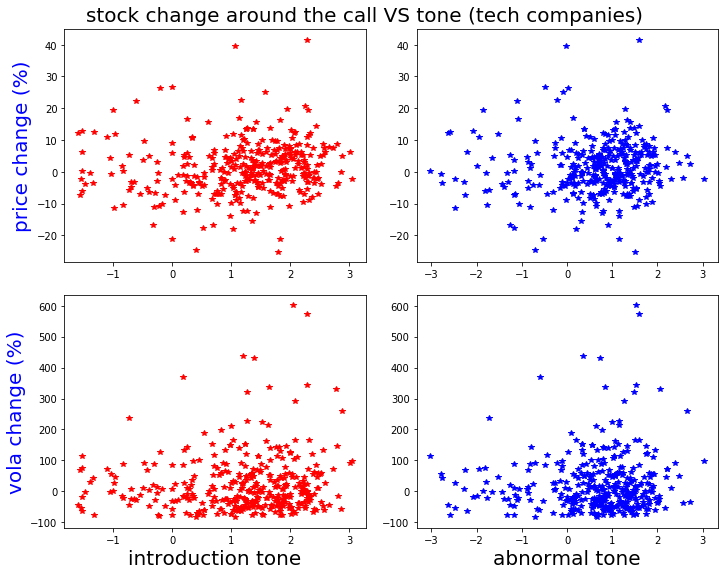

In [18]:
plot_senti_vs_stock(data_all,"tech companies")

In [19]:
len(data_all)

363

In [20]:
len(earnings_stock)

485

# implement decision tree regressor 

In [21]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.tree import export_graphviz  
from sklearn.model_selection import KFold


In [22]:
X = data_all[['eps','tone_ab']]
y = data_all[['price_change','vola_change']]

In [93]:
# Fit a decision tree regressor to the data
# Use k-fold cross validation to find the optimal hyperparameter (tree depth)
def find_best_model(X,y,n_splits,depths):
    
    scores = []
    kf = KFold(n_splits = n_splits, shuffle = True, random_state = 9)
    for depth in depths:
        
        kscore = []
        # Compute the test score of the model for each of K folds at fixed tree depth
        for train_index, test_index in kf.split(X):
            X_train,X_test = X.iloc[train_index],X.iloc[test_index]
            y_train,y_test = y.iloc[train_index],y.iloc[test_index]
            regressor = DecisionTreeRegressor(max_depth = depth)
            regressor.fit(X_train, y_train)
            test_score = regressor.score(X_test, y_test)
            kscore.append(test_score)    
        scores.append(np.max(kscore))
            
    return scores   
    

Text(0,0.5,'Test score of the tree')

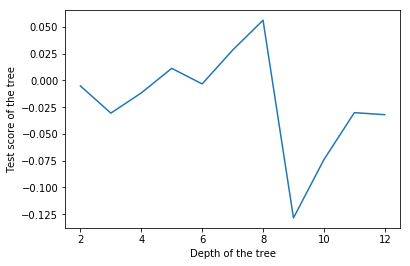

In [94]:
depths = list(range(2,13))
n_splits = 10
scores = find_best_model(X, y, n_splits, depths)
plt.plot(depths, scores)
plt.xlabel('Depth of the tree')
plt.ylabel('Test score of the tree')

### The best tree depth is 8

In [95]:
# Fit a decision tree of depth 8 with all data
regressor = DecisionTreeRegressor(max_depth = 8)
regressor.fit(X, y)

DecisionTreeRegressor(criterion='mse', max_depth=8, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=None, splitter='best')

In [97]:
y_pred = regressor.predict(X)

In [98]:
regressor

DecisionTreeRegressor(criterion='mse', max_depth=8, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=None, splitter='best')

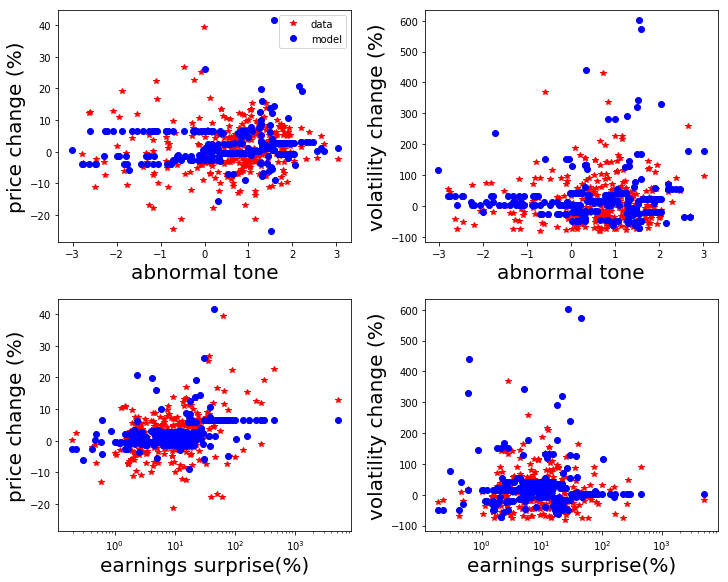

In [99]:
fig,axs = plt.subplots(2,2,figsize = (10,8),constrained_layout=True)
#fig.suptitle('stock change around earnings call VS prediction',fontsize = 20)
axs[0,0].plot(X['tone_ab'],y['price_change']*100,'r*')
axs[0,0].plot(X['tone_ab'],y_pred[:,0]*100,'bo')
axs[0,0].tick_params('abnormal tone', colors='r')
axs[0,0].set_ylabel('price change (%)', color='k',fontsize = 20)
axs[0,0].set_xlabel('abnormal tone',fontsize = 20)
axs[0,0].legend(['data','model'])

axs[0,1].plot(X['tone_ab'],y['vola_change']*100,'r*')
axs[0,1].plot(X['tone_ab'],y_pred[:,1]*100,'bo')
axs[0,1].tick_params('abnormal tone', colors='r')
axs[0,1].set_ylabel('volatility change (%)', color='k',fontsize = 20)
axs[0,1].set_xlabel('abnormal tone',fontsize = 20)

axs[1,0].plot(X['eps'],y['price_change']*100,'r*')
axs[1,0].plot(X['eps'],y_pred[:,0]*100,'bo')
axs[1,0].set_xlabel('earnings surprise(%)',fontsize = 20)
axs[1,0].tick_params('earnings surprise', colors='r')
axs[1,0].set_ylabel('price change (%)', color='k',fontsize = 20)
axs[1,0].set_xscale('log')

axs[1,1].plot(X['eps'],y['vola_change']*100,'r*')
axs[1,1].plot(X['eps'],y_pred[:,1]*100,'bo')
axs[1,1].tick_params('earnings surprise', colors='r')
axs[1,1].set_ylabel('volatility change (%)', color='k',fontsize = 20)
axs[1,1].set_xscale('log')
axs[1,1].set_xlabel('earnings surprise(%)',fontsize = 20)

plt.show()    
fig.savefig('/Users/leonardo_da_cina/Desktop/stock_vs_model.png')

In [100]:
# Save the model 
p = os.path.join(os.getcwd(), "stock_prediction_model.v2")
with open(p, 'wb') as f:
    pickle.dump(regressor, f)

In [101]:
# Reload the model
p = os.path.join(os.getcwd(), "stock_prediction_model.v2")
with open(p, 'rb') as f2:
    model = pickle.load(f2)